<a href="https://colab.research.google.com/github/RitaDCassia/swin_transformer/blob/main/Untitled121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install einops

In [20]:
import torch
from torch import nn, einsum
import numpy as np

from einops import rearrange

import torch.nn.functional as f

In [21]:
class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    return self.fn(x, **kwargs) + x

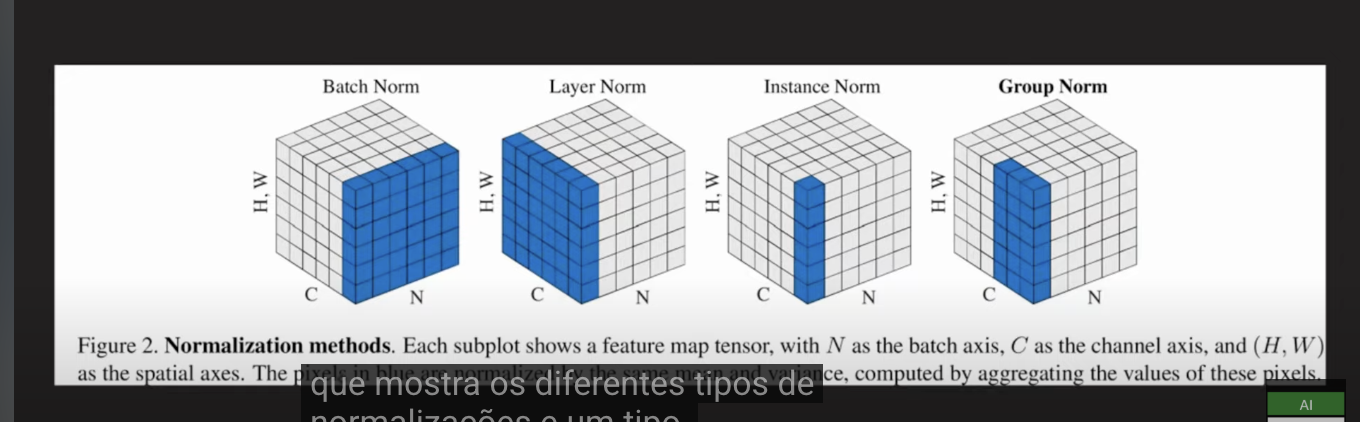

Sabemos que nas nossas camadas cada pixel é um tpken e vamos normalizar cada token em relação a si mesmo, se eu tiver um token amarelo e quiser normaliza-lo nao devo considerar nenhum elemento to token rosa

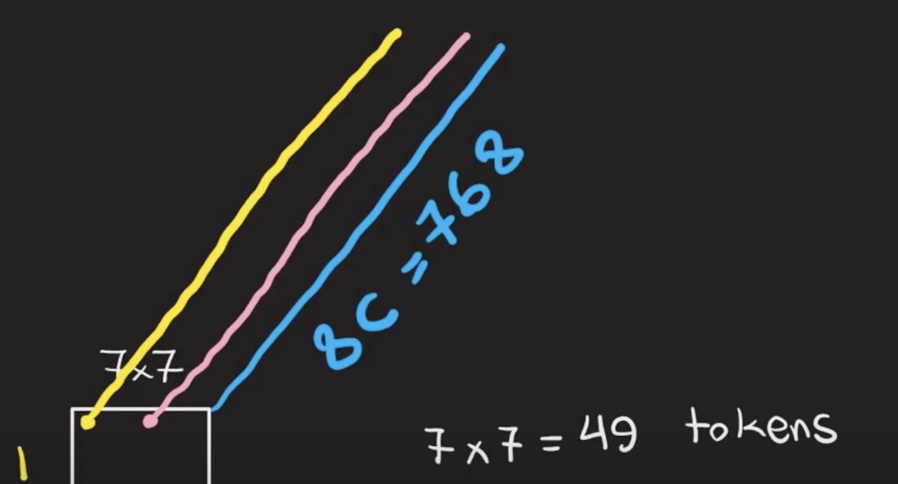

quando fazemos uma norma de camada nesse caso é um pouco diferente, podemos ter um token que vamos normalizar de forma idependente de outros tokens

In [22]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim) # estamos usando a norma da camada de pontos nn
    # que é una funcao pytorch que recebe uma entrada de dimencao que seria o numero de canais
    self.fn = fn

  def forward(self, x, **kwargs):
    #return self.fn(self.norm(x), **kwargs) # pre norm versao 1
    return self.norm(self.fn(x, **kwargs)) # pos norm versao 2

In [23]:
# exemplo com numeros
torch.manual_seed(0)
B, H, W, C = 1, 2, 2, 3 # definindo um tensor aleatorio
# 4 tokens, numero de canaais 3

input = torch.randn(B, H, W, C)*100
print('saida: ', input)

# usando a norma da camada e teresmos a saida
layer_norm = nn.LayerNorm(C)
output = layer_norm(input)
print('saida: ', output)

saida:  tensor([[[[ 154.0996,  -29.3429, -217.8789],
          [  56.8431, -108.4522, -139.8595]],

         [[  40.3347,   83.8026,  -71.9258],
          [ -40.3344,  -59.6635,   18.2036]]]])
saida:  tensor([[[[ 1.2191,  0.0112, -1.2303],
          [ 1.3985, -0.5173, -0.8813]],

         [[ 0.3495,  1.0120, -1.3615],
          [-0.3948, -0.9787,  1.3735]]]], grad_fn=<NativeLayerNormBackward0>)


In [24]:
class FeedForward(nn.Module):
  def __init__(self, dim, hidden_dim):
    super().__init__()
    self.net = nn.Sequential(
        # nao linear
        nn.Linear(dim, hidden_dim),
        # funcao de ativação com gelu e pra a segunda camada apenas uma camada lienar
        # pra o tamanho das dimensoes ocultas
        # vamos usar quatro vezes o tamanho da entrada para nos é o numero de canais
        # ex: se 96 multiplicamos 96 por 4
        nn.GELU(), # quando negativo nao é totoalmente zero é um numero negativo
        nn.Linear(hidden_dim, dim)
    )

  def forward(self, x):
    return self.net(x) # selfnet é definido aqui como uma rede neural de duas camadas
    # totalmente conectada

Tecnica de preenchimento chamada de deslocamento ciclico

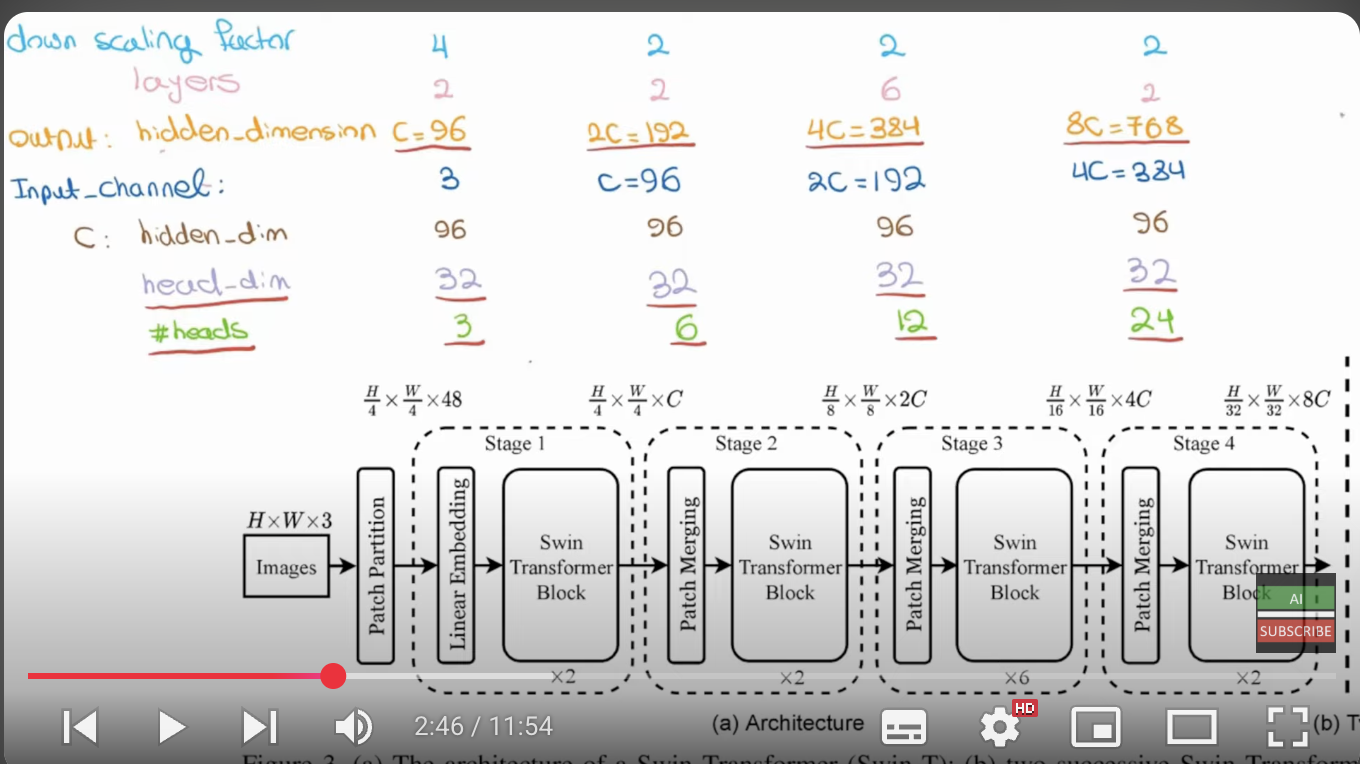

quando deslocamos o  a janela ficamos com um espaço em branco, para arrumarmos isso precisamos ver o artigo

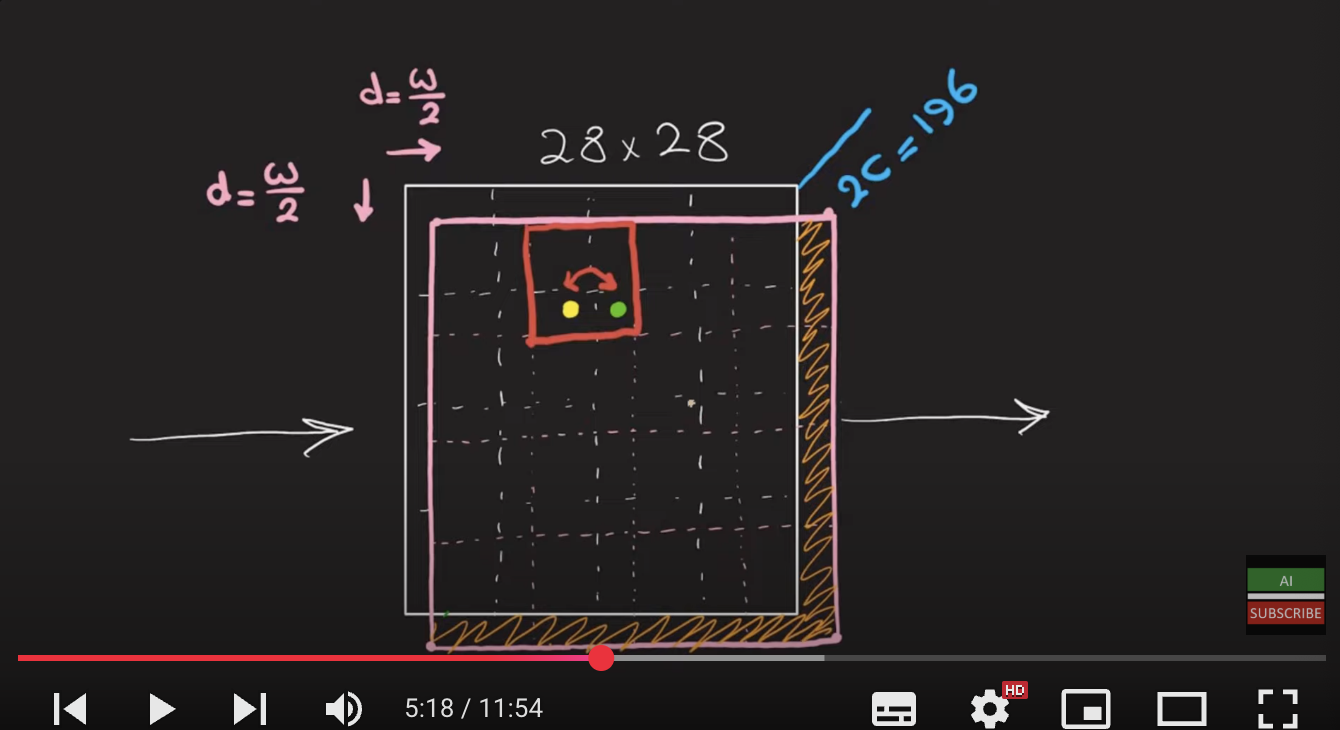

a tabela mostra a velocidade real de diferentes metodos de computacao e autoatencao e implementacoes em uma cpu 300. temos o preenchimento faca que apenas aidciona zeros aos locais vazios. tambem, tem o cliclo e mostra a diferenca de velicidade entre os dois. para o estagio um conseguimos ver que o clico é mais rapido tambem pra o restantes dos estagios, logo, podemos ver que a mudança ciclica é mais eficiente para o swin transformer
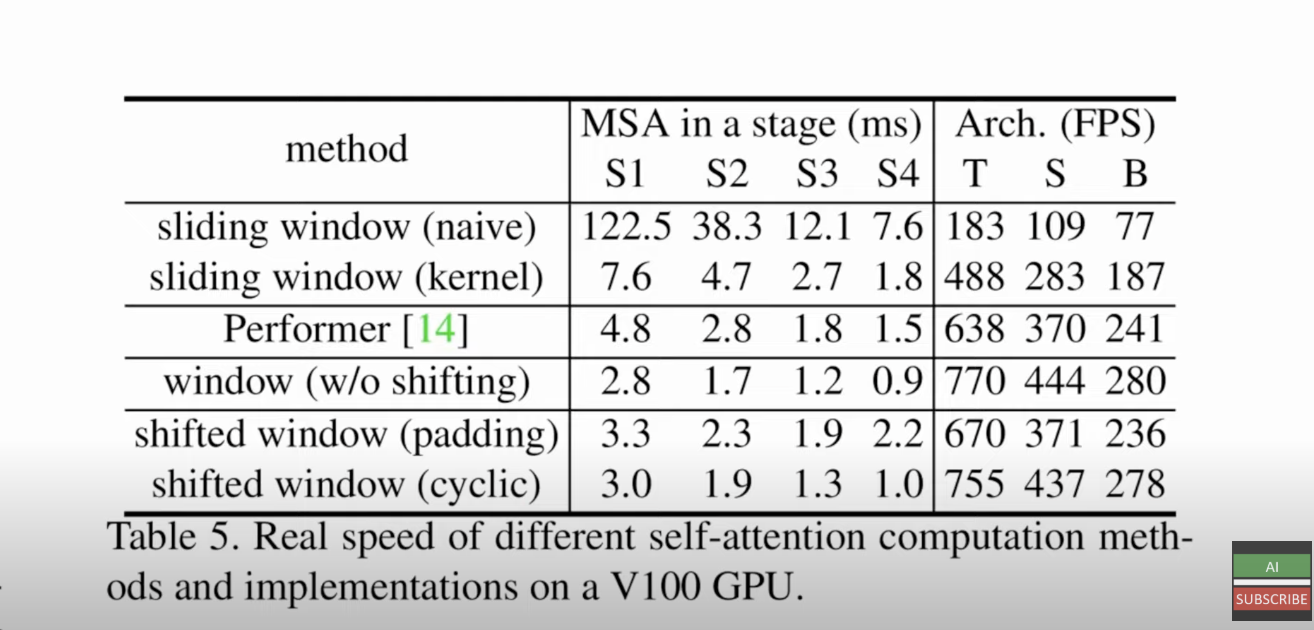

então, vamos olhar os detalges do preeenchimenoto cciclico. nas seções basicamente copiamos e colamos. por exemplo, em um segundo estagio pra preencher os locais vazios pegamos a seção do totpo, os verdes e apenas copiamos e colamos em baixo e fazemos isso pra todas
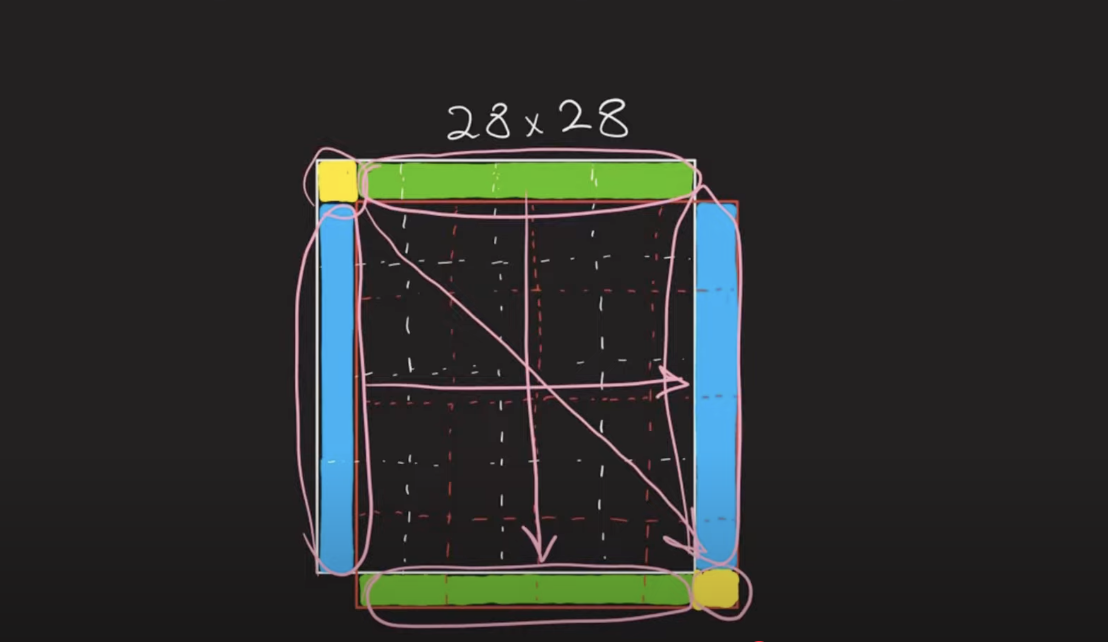

In [25]:
class CyclicShift(nn.Module):
  # obtemos o deslocamento como entrada
  def __init__(self, displacement):
    super().__init__()
    self.displacement = displacement

  def forward(self, x):
    # usamos o torch.roll e vamos dizer que como o tensor está rolando entao vamos rolar ele em
    # relacao a dimensao 1 e 2
    return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

In [26]:
# exemplo: temos uma matriz 9x9 com numeros entre 1 e 81
x = torch.linspace(1, 81, 81).view(9, 9)
print('Tensor original:')
print(x)

# tambem vamos deslocar um -1 na primeira e segunda dimensao
# definimos tambem a dimensao zero e um que serao o que vamos conduzir um rolo
y = torch.roll(input=x, shifts=(-1, -1), dims=(0, 1))
print('Tensor deslocado:')
print(y)

Tensor original:
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18.],
        [19., 20., 21., 22., 23., 24., 25., 26., 27.],
        [28., 29., 30., 31., 32., 33., 34., 35., 36.],
        [37., 38., 39., 40., 41., 42., 43., 44., 45.],
        [46., 47., 48., 49., 50., 51., 52., 53., 54.],
        [55., 56., 57., 58., 59., 60., 61., 62., 63.],
        [64., 65., 66., 67., 68., 69., 70., 71., 72.],
        [73., 74., 75., 76., 77., 78., 79., 80., 81.]])
Tensor deslocado:
tensor([[11., 12., 13., 14., 15., 16., 17., 18., 10.],
        [20., 21., 22., 23., 24., 25., 26., 27., 19.],
        [29., 30., 31., 32., 33., 34., 35., 36., 28.],
        [38., 39., 40., 41., 42., 43., 44., 45., 37.],
        [47., 48., 49., 50., 51., 52., 53., 54., 46.],
        [56., 57., 58., 59., 60., 61., 62., 63., 55.],
        [65., 66., 67., 68., 69., 70., 71., 72., 64.],
        [74., 75., 76., 77., 78., 79., 80., 81., 73.],
        [ 2.,  3.,  4.,  5., 

artigo VIT 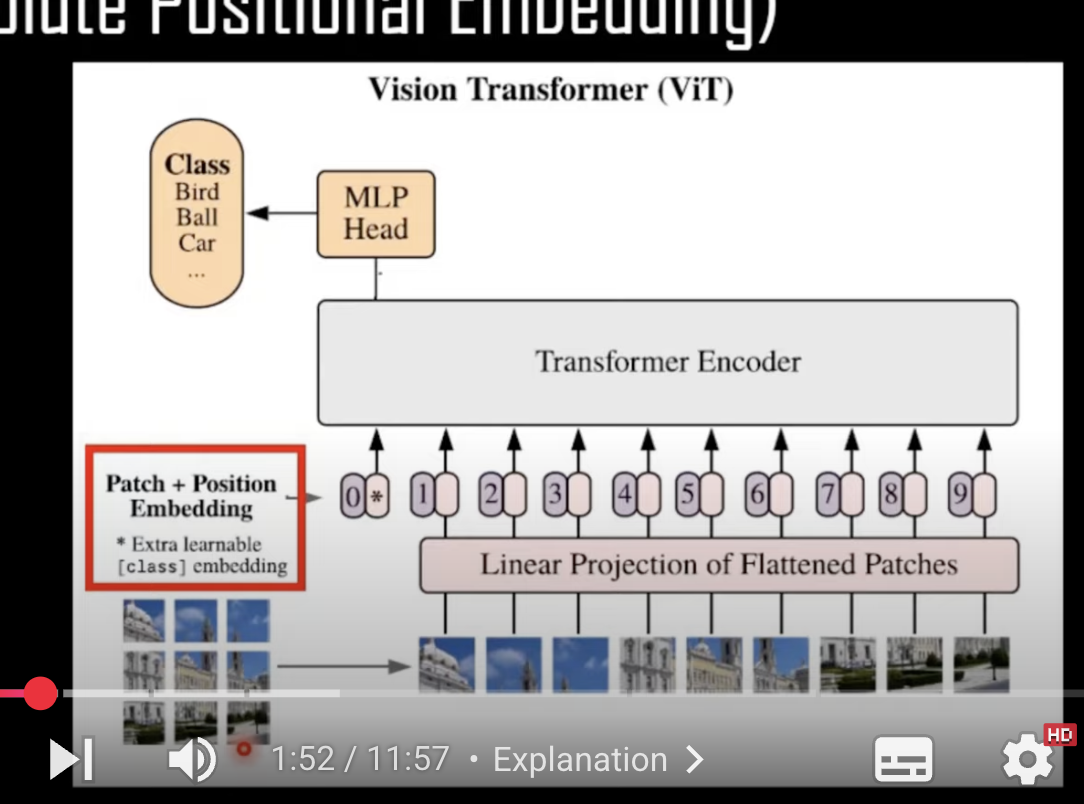


janelas

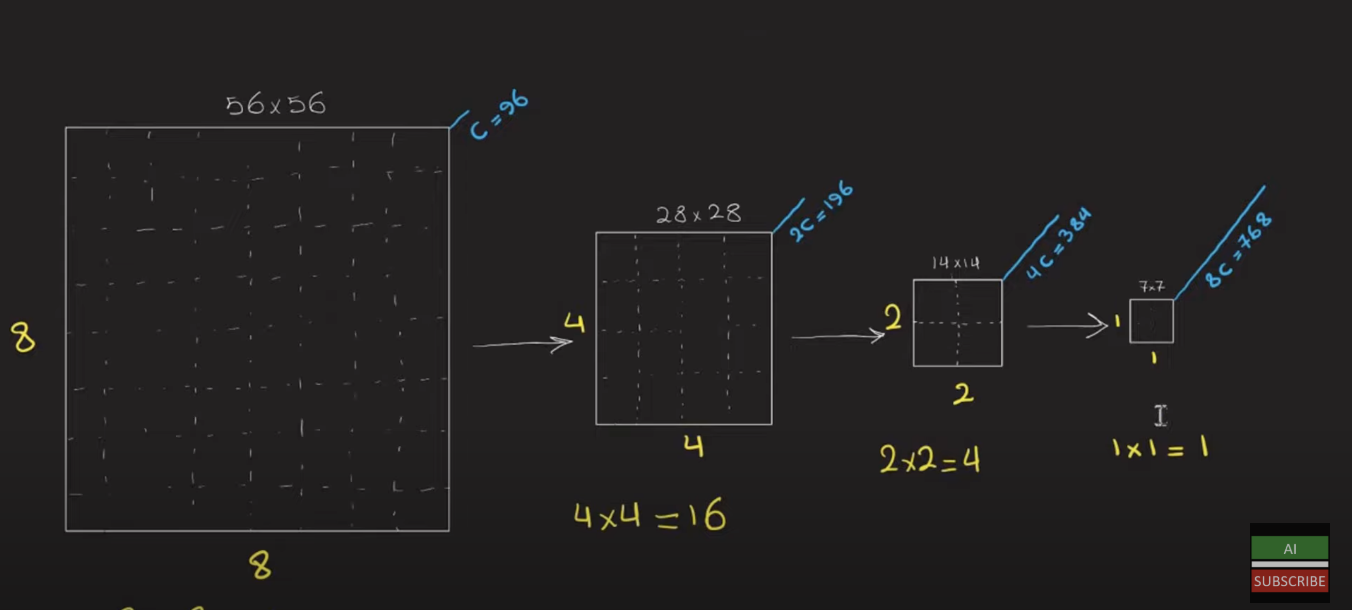

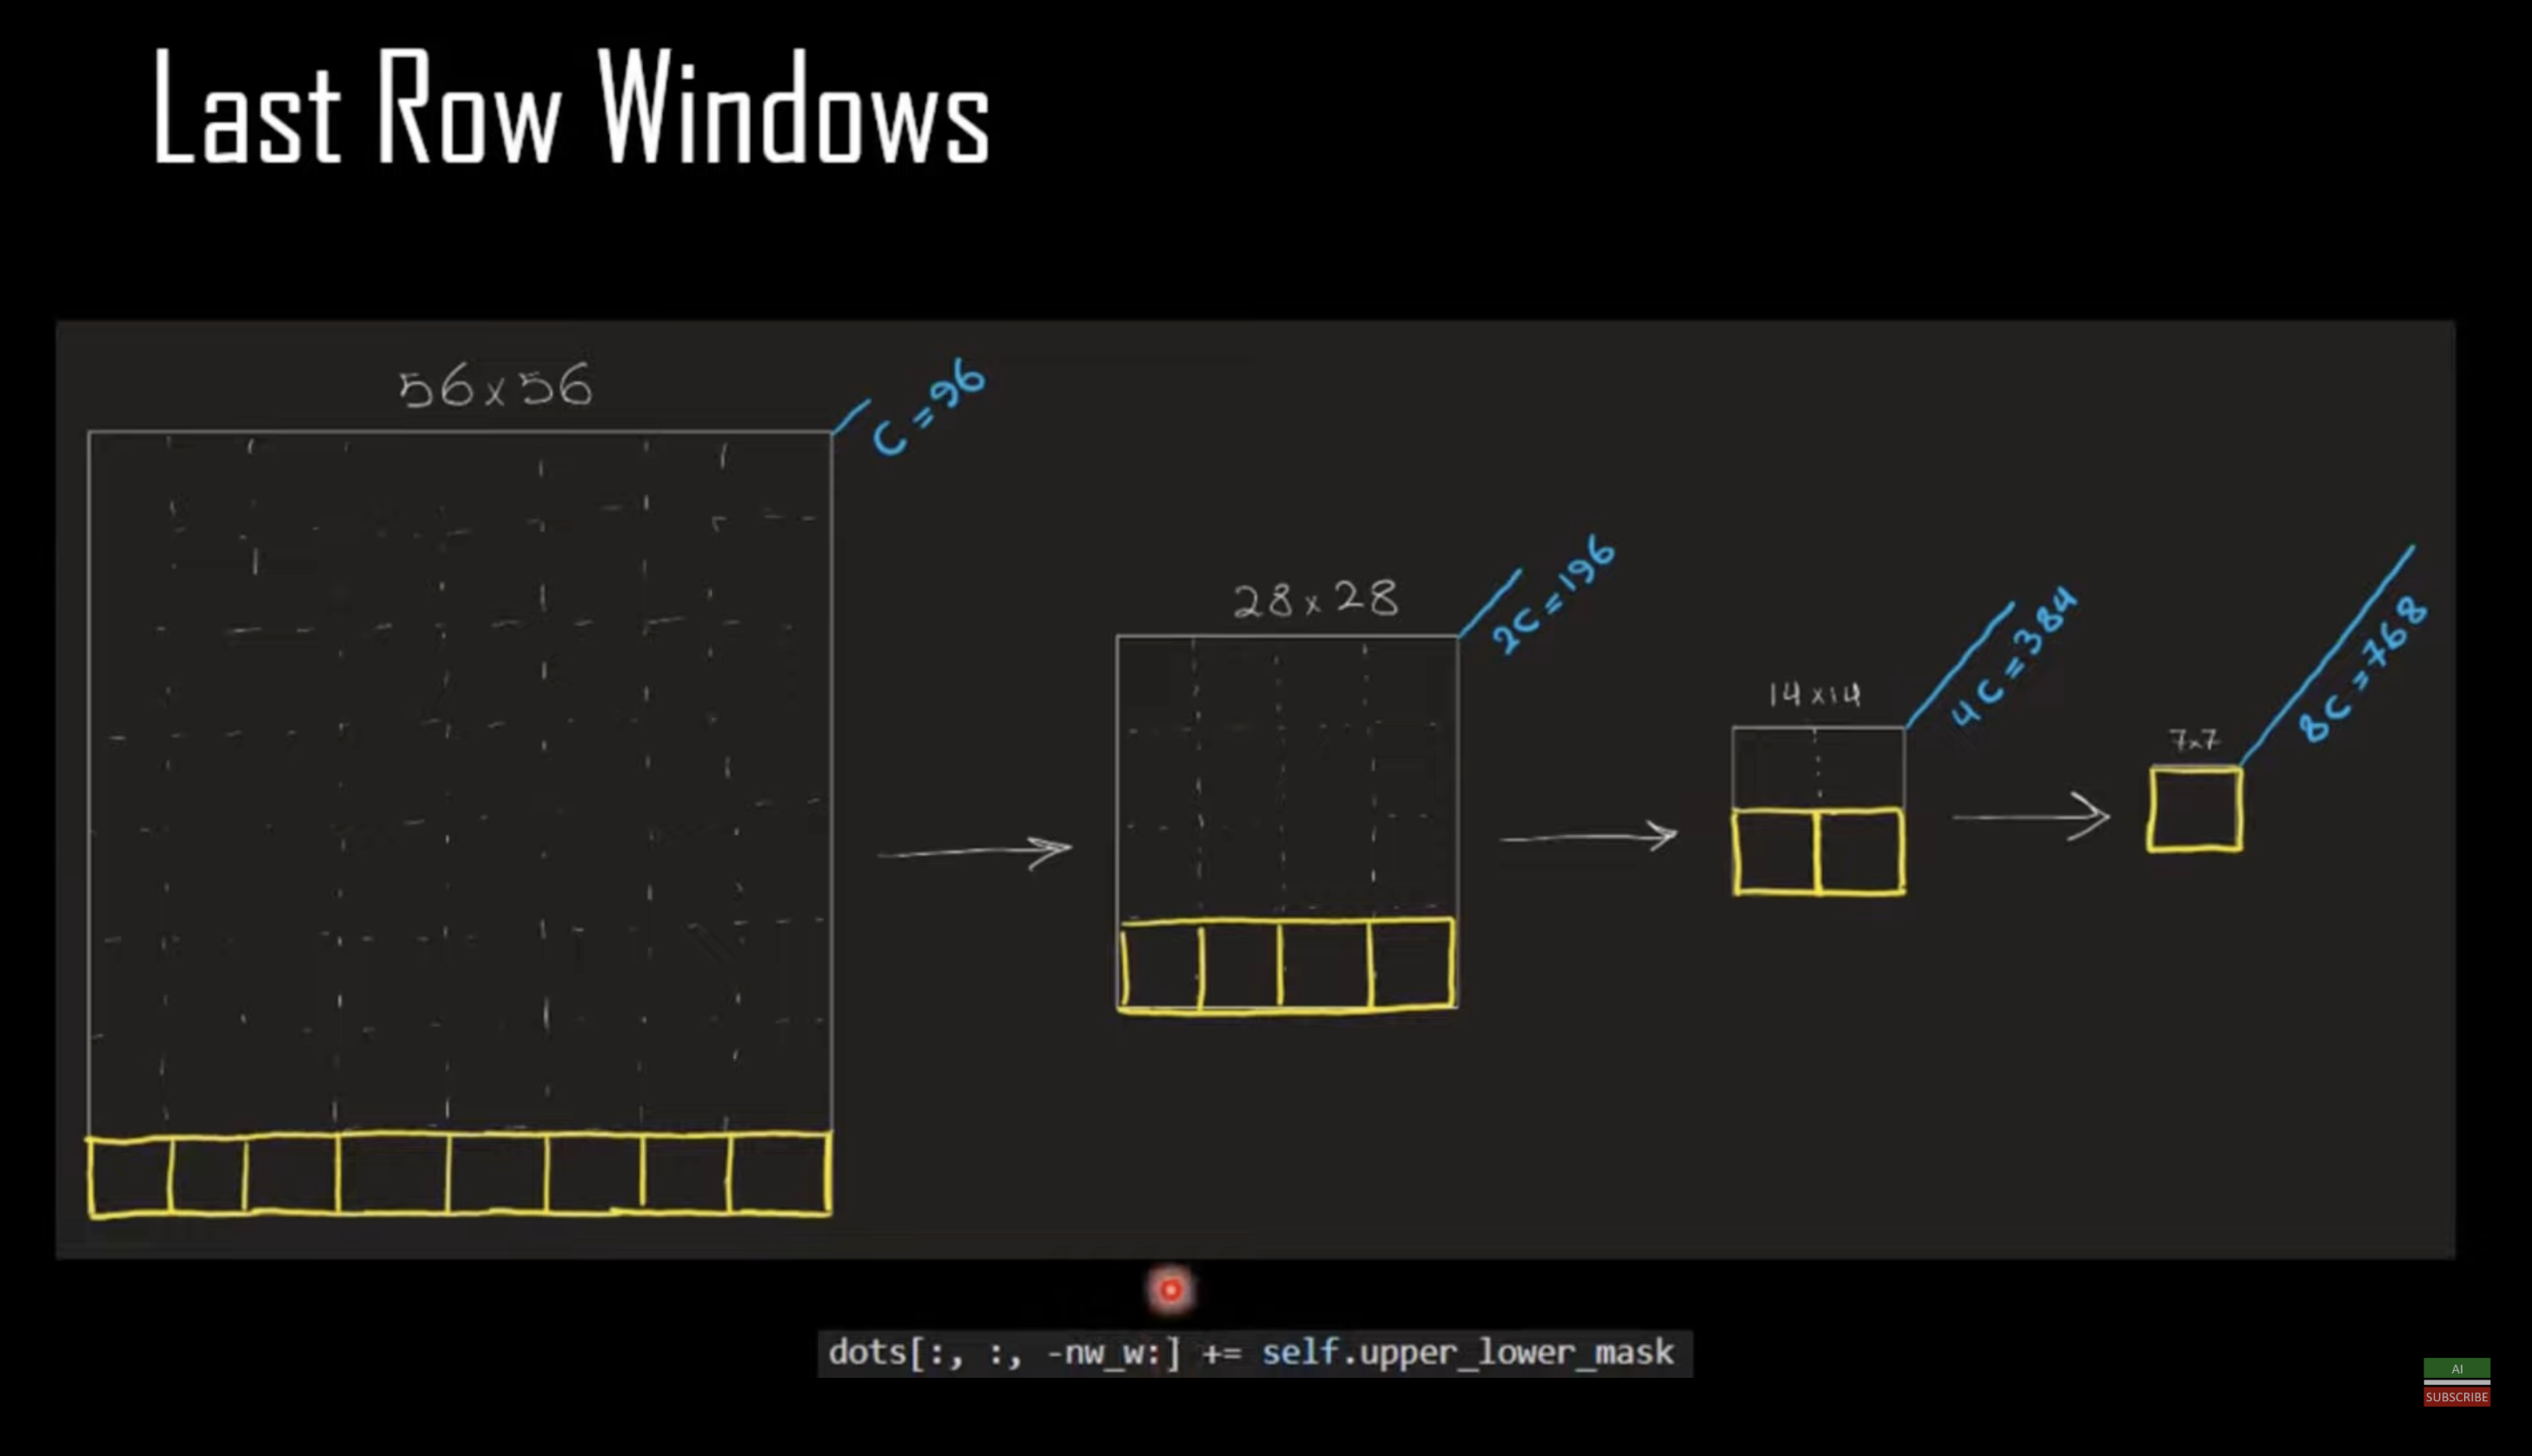

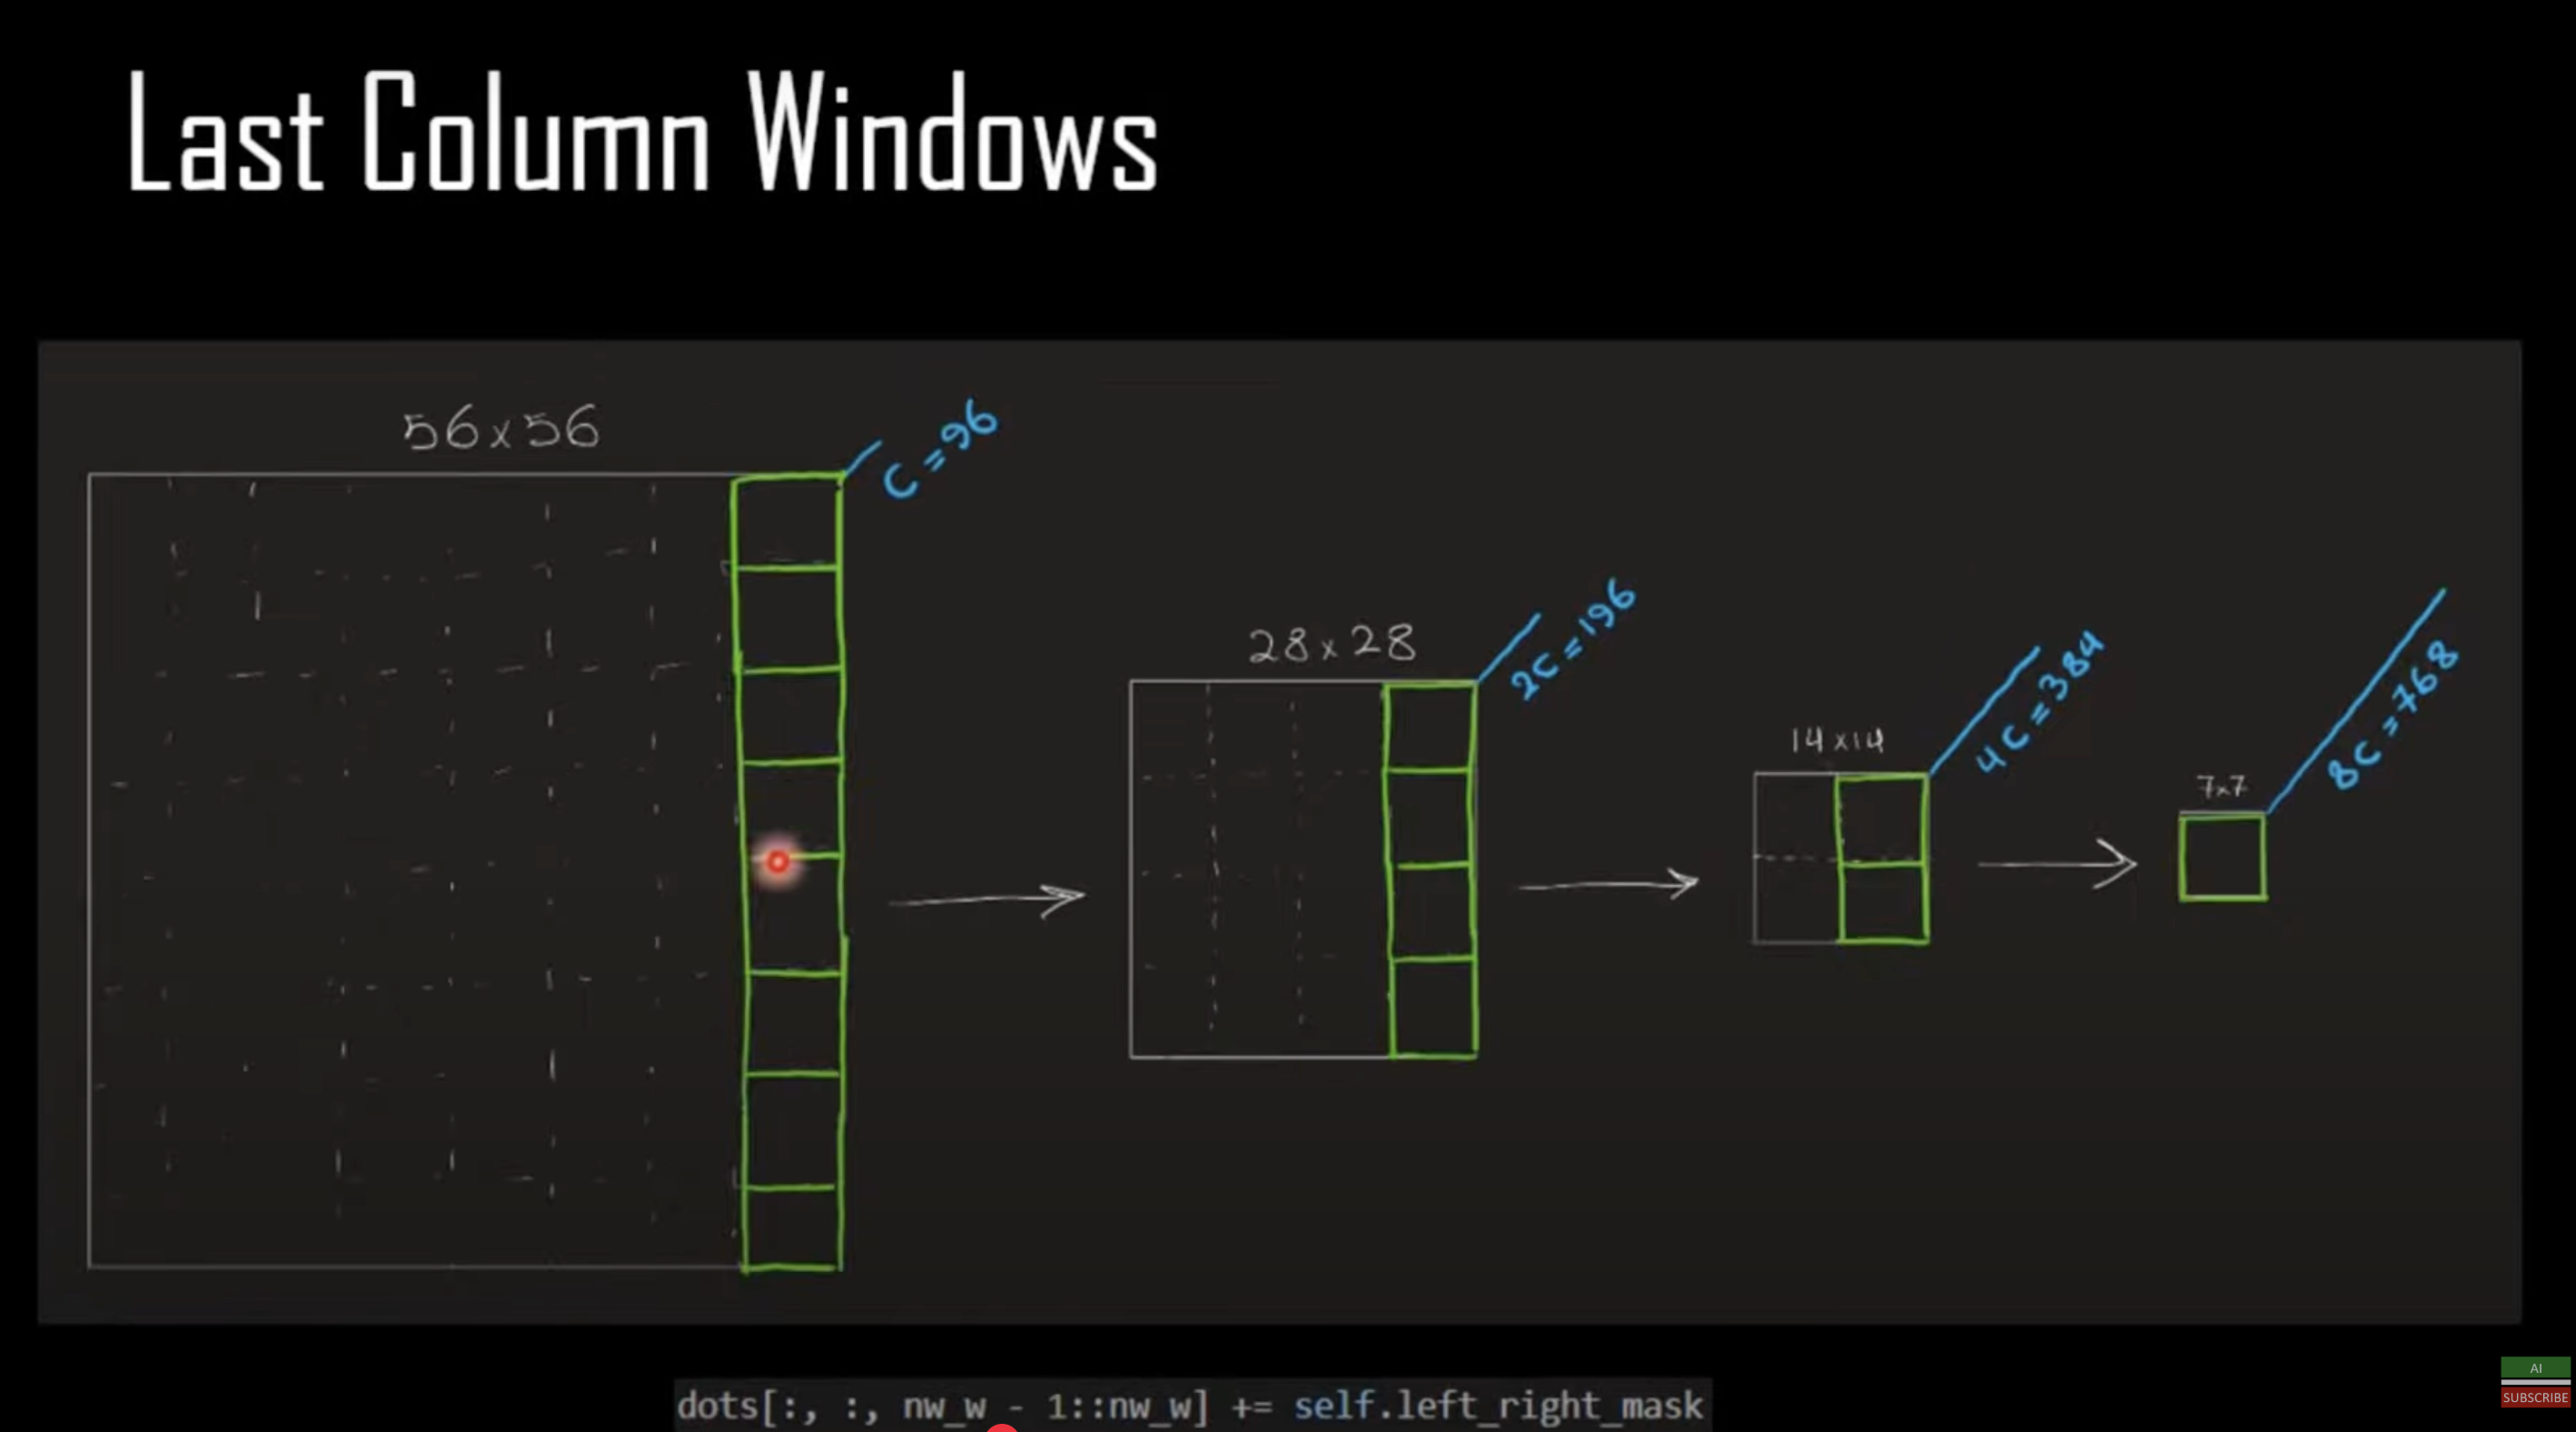

In [27]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

In [28]:
class WindowAttention(nn.Module):
  # dim - dimensões
  # heads e head_sim tambem
  # nossas dimensoes vão ser iguais aos numeros de canais
  # dim=hidem_dim = (96, 192, 384, 768)
  # cabecas sao iguais ao numero de cabeas que temos
  # heads = num_heads(3, 6, 12, 24)
  # head_dim = 32 dimensao da cabeca
  # temos uma camada chamada dimensao oculta, essa numensao oculta é basicamente o numero de camais para o estagio um
  # 96 para o estagio 2 é 2c ou 192 para o proximo estagio é 4c e o proximo 8c que é 768
  #
  def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
    super().__init__()

    # a dimensao interna sera igual o numero de cabecas
    inner_dim = head_dim * heads

    self.heads = heads
    self.scale = head_dim ** -0.5 # D é basicamente a dimensao da cebeça que é 32 que é elevado agora a -0.5
    self.window_size = window_size # nossa janela é 7
    self.relative_pos_embedding = relative_pos_embedding # posicao relativa
    self.shifted = shifted # deslocamento que vai nos dizer se é janela ou janela deslocada

    #
    if self.shifted:
      # a primeira coisa que faremos ;e defiiniar quantos pixels vamos deslocar
      # entao, dissemos que isso será a metade do tamanho da janela
      displacement = window_size // 2 # 7//2 = 3 - consideramos apenas o valor obsoluto (3 pixels) da direita pra baixo
      # entao definimos a funcao para deslocamento de ciclo, pois devemos ser capazes de deslocar janelas ao mesmo tempo
      # e deslocar de volta pra o que era antes

      self.cyclic_shift = CyclicShift(-displacement)
      self.cyclic_back_shift = CyclicShift(displacement)

      self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                       upper_lower=True, left_right=False), requires_grad=False)

      self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                       upper_lower=False, left_right=True), requires_grad=False)

    # precisamos dessa camada linear, que é uma dimensão do numero de canais que temos
    # e a saida tammbem é a dimensao interna, que é igual ao numero de canais multiplicados por tres
    # criamos isso pq vamos criar a nossa chave de valores de consulta usando o tensor que estamos obtendo como entrada
    # e em seguida incluiremos nossa imcorporação posicional
    self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

    # usaremos uma incorporação pisicional por enquanto e depois alteramos
    # dizemos que 12 f2 é o tamanho da janela elevado a 2
    # no artigo vit entendemos que cada patch em si é um token, mas quando dividimos a imagem
    # em patches precisamos registrar as informações de onde esse patch pertence
    self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2)) # (49, 49)

    # aqui temos uma camada linear, a entrada é a dimensão interna
    # a dimensao interna é a dimensão da cabeça
    self.to_out = nn.Linear(inner_dim, dim) # (96, 192, 384, 768)

  # finalmente podemos começar a criar a nossa seção de avanço de classe
  # a primeira coisa é decidir se é um bloco ou um bloco deslocado
  # se for, enviaremos o nosso tensor de entrada para o deslocamento ciclico
  # ele fará o deslocamento para nós
  # valor de entrada para x: (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
  def forward(self, x):
    if self.shifted:
      #print('x size:, x.size()') # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
      x = self.cyclic_shift(x)
      #print('x size:, x.size()') # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
      # sabemos que o tamanho do cliclo nao muda o tamanho do nosso tensor, entao a saida é sempre do mesmo tamanho
    # agora vamos obter o primeiro elemento, que sera o tamanho do lote e entao temos o 56 pra a altura e pra os bits
    # h serão cabeças para nós que definimos
    b, n_h, n_w, _, h = *x.shape, self.heads # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
    # vamos conseiderar a linha de inicializacao
    # o tamanho das janelas nao mudam mas o numero de canais será multiplicado por 3
    #print('self.to_qkv(x): ', self.to_qkv(x).size()) # (1, (56, 28, 14, 7), (56, 28, 14, 7), (288, 576, 1152, 2304))
    # entao usamos a funcao chunck e a dividiremos em tres tensores
    qkv = self.to_qkv(x).chunk(3, dim=-1)
    #print('qkv: ', qkv[0].size())
    # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
    # a proxima coisa que queremos saber é quantas janelas temos em estágio
    # pra isso vamos dividir uma arasta pelo tmanaho da janela
    nw_h = n_h // self.window_size # (56//7-8, 28//7-4, 14//7-2, 7//7-1)
    nw_w = n_w // self.window_size # (56//7-8, 28//7-4, 14//7-2, 7//7-1)
    # no final teremos apenas uma janela
    # agora vamos reorganizar esse qkv
    # b é o tach size, o tamanho do nosso lote
    # nw_h - multiplicamos com o tamanho da janela, seria 8 * 7 - 56
    # a mesma coisa pra o nw_w: 7*8 = 56
    # h d - tamanho da cabeça - 32
    # (1, 56, 56, )
    q, k, v = map(
        lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                            h=h, w_h=self.window_size, w_w=self.window_size), qkv)
    # print('q size: ' q.size())
    # b estao no primeiro lote entao temos h pra o primeiro estagio
    #(b=1, h=(3, 6, 12, 24), (nw_h * nw_w) = (64, 16, 4, 1), (w_h*w_w)=49, d=32)
    # where d-head_dim; h=#heads
    # print('k size: ' k.size()) # mesmo que q
    # print('v size: ' v.size()) # mesmo que q
    # para fazermos a funcao ela reebera duas entradas a prmeira é q e a sefunda k
    # olhando pra a dimensao do q temos que que é b pra o tamanho do lote que é igual a 1
    # entao temos H, H é o numero de cabeças pra o primeiro estagio entao temos w, w será 64
    # isso significa quantas janelas temos
    # temos i que é 49, entao temos d que é 32
    # i e j sao nós
    # e entao temos a entrada k, essa é a simentao do k :  b h w i j que seria novamente 49
    # a saida seria novamente um lote de nuemro de cabeças de l]janelas entao i e j serao 49
    dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

    # quando adicionamos uma matriz 49 por 49 aos meus pontos ela vai atuar em todas aas janelas que eu tenho
    # b-batch_size, h-heads (3, 6, 12, 24), w=(64, 16, 4, 1), j = 49
    # quando adiciono o embedding quer dizer que estou adicionando a incorperação em todos os tensores/janelas
    dots += self.pos_embedding
    # precisamos adicionar uma mascara
    # se uma janela for deslocada e se o deslocado for verdadeiro sabemos que temos massa superior inferior e mascara esquerda direita e o tamanho
    # de cada uma delas é 49
    # adicionamos essas marcadas apenas as janelas na ultima linha e coluna
    if self.shifted:
      #tmp1= upper_lower_mask   # (49, 49)
      #tmp2= left_right_mask   # (49, 49)
      # mascadas superiores e inferiores pra a ultima coluna
      # nesse caso, usando esse codigo conseguimos mascarar as janelas da ultima camada como mostrado na imagem a cima
      dots[:, :, -nw_w] += self.upper_lower_mask
      # nese caso, queremos apenas mascarar as janelas da ultima linha como mostrado na imagem a cima
      dots[:, :, nw_w - 1::nw_w] += self.left_right_mask
    # agora usamos a funcao softmax
    # obtemos a atencao e tambem o tamanho da saida será
    # b=batch_size, h=#heads (3, 6, 12, 24), w=(64, 16, 4, 1), i=49, j=49
    attn = dots.softmax(dim=-1)
    # multiplicamos pelo nosso valor
    # (b=1, h-(3, 56, 12, 24), (nw_h*nw_w)=(64, 16, 4, 1), (w_h*w_w)=49, d=32 enquanto d=head_dim; h=#heads)
    # vamos usar esse pra multiplcar a saída do softmax
    # tamanho do lote é um numero de cabeças h
    # w numero de janelas i e j sao 49
    out = einsum('b h w i j, b h w i d -> b h w i d', attn, v)
    # agora precisamos gerar a saida pra o tensor original
    # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
    # forma de entrada no estagio 1: b h (nw_g nw_e) (w_h w_w) d
    # a forma de saida será essa: b (nw_h w_h) (nw_w w_w) (h d)
    # e agora temos tudo de volta ao formato origial
    # out = rearrange(out, 'b h (nw_g nw_e) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
    #                 h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
    # CORRETO:
    out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)

    # depois disso usaremos as nossas duas camadas e nao mudará o formato do nosso tensor
    out = self.to_out(out)
    # se o deslocado for verdadeiro estamos em uma janela deslocada e precisamos fazer o cliclo de volta pra o formato original
    # pra ai sim enviar ela pra o proximo bloco colocando o valor positvo pra o deslocamento
    if self.shifted:
      out = self.cyclic_back_shift(out)
    # apenas retornando a saida
    return out

In [29]:
# exemplo numerico
do = torch.rand(1, 1, 2, 5, 5)
print('do: ', do)

po = torch.ones(5, 5)
print('do: ', po)

su = do + po
print('do3: ', su)

do:  tensor([[[[[0.4194, 0.5529, 0.9527, 0.0362, 0.1852],
           [0.3734, 0.3051, 0.9320, 0.1759, 0.2698],
           [0.1507, 0.0317, 0.2081, 0.9298, 0.7231],
           [0.7423, 0.5263, 0.2437, 0.5846, 0.0332],
           [0.1387, 0.2422, 0.8155, 0.7932, 0.2783]],

          [[0.4820, 0.8198, 0.9971, 0.6984, 0.5675],
           [0.8352, 0.2056, 0.5932, 0.1123, 0.1535],
           [0.2417, 0.7262, 0.7011, 0.2038, 0.6511],
           [0.7745, 0.4369, 0.5191, 0.6159, 0.8102],
           [0.9801, 0.1147, 0.3168, 0.6965, 0.9143]]]]])
do:  tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
do3:  tensor([[[[[1.4194, 1.5529, 1.9527, 1.0362, 1.1852],
           [1.3734, 1.3051, 1.9320, 1.1759, 1.2698],
           [1.1507, 1.0317, 1.2081, 1.9298, 1.7231],
           [1.7423, 1.5263, 1.2437, 1.5846, 1.0332],
           [1.1387, 1.2422, 1.8155, 1.7932, 1.2783]],

          [[1.4820, 1.8198, 1.

In [30]:
class SwinBlock(nn.Module):
  def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
    super().__init__()

    # no atenção temos
    # residual, norma da camada a atenção da janela
    self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                 heads=heads,
                                                                 head_dim=head_dim,
                                                                 shifted=shifted,
                                                                 window_size=window_size,
                                                                 relative_pos_embedding=relative_pos_embedding)))
    # para o perceptron block temos
    # o residual, o a norma da camada e o feed forward
    self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim,
                                                       hidden_dim=mlp_dim)))

  # temos x como entrada e ele primeiro entra no bloco de atencao
  # depois entra no bloco de perceptron multicamadas e depois temos a saida
  def forward(self, x):
    x = self.attention_block(x)
    x = self.mlp_block(x)
    return x

In [31]:
class PatchMerging_Conv(nn.Module):
  def __init__(self, in_channels, out_channels, downscaling_factor):
    super().__init__()

    # o kernel_size e o stide precisam ser iguais
    # significa que os kerles nao se sobrepoem quando vao mais longe que é como obtemos quadro por quadro
    # e entao pula pra o proximo
    self.patch_merge = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=downscaling_factor,
                                 stride=downscaling_factor,
                                 padding=0)

  #( 1, (3, 96, 192, 384), (244, 56, 28, 14), (244, 56, 28, 14))
  # (1, (96, 192, 384, 768), (56, 28, 14, 7), (56, 28, 14, 7))
  # (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
  def forward(self, x):
    x = self.patch_merge(x).permute(0, 2, 3,1)
    return x

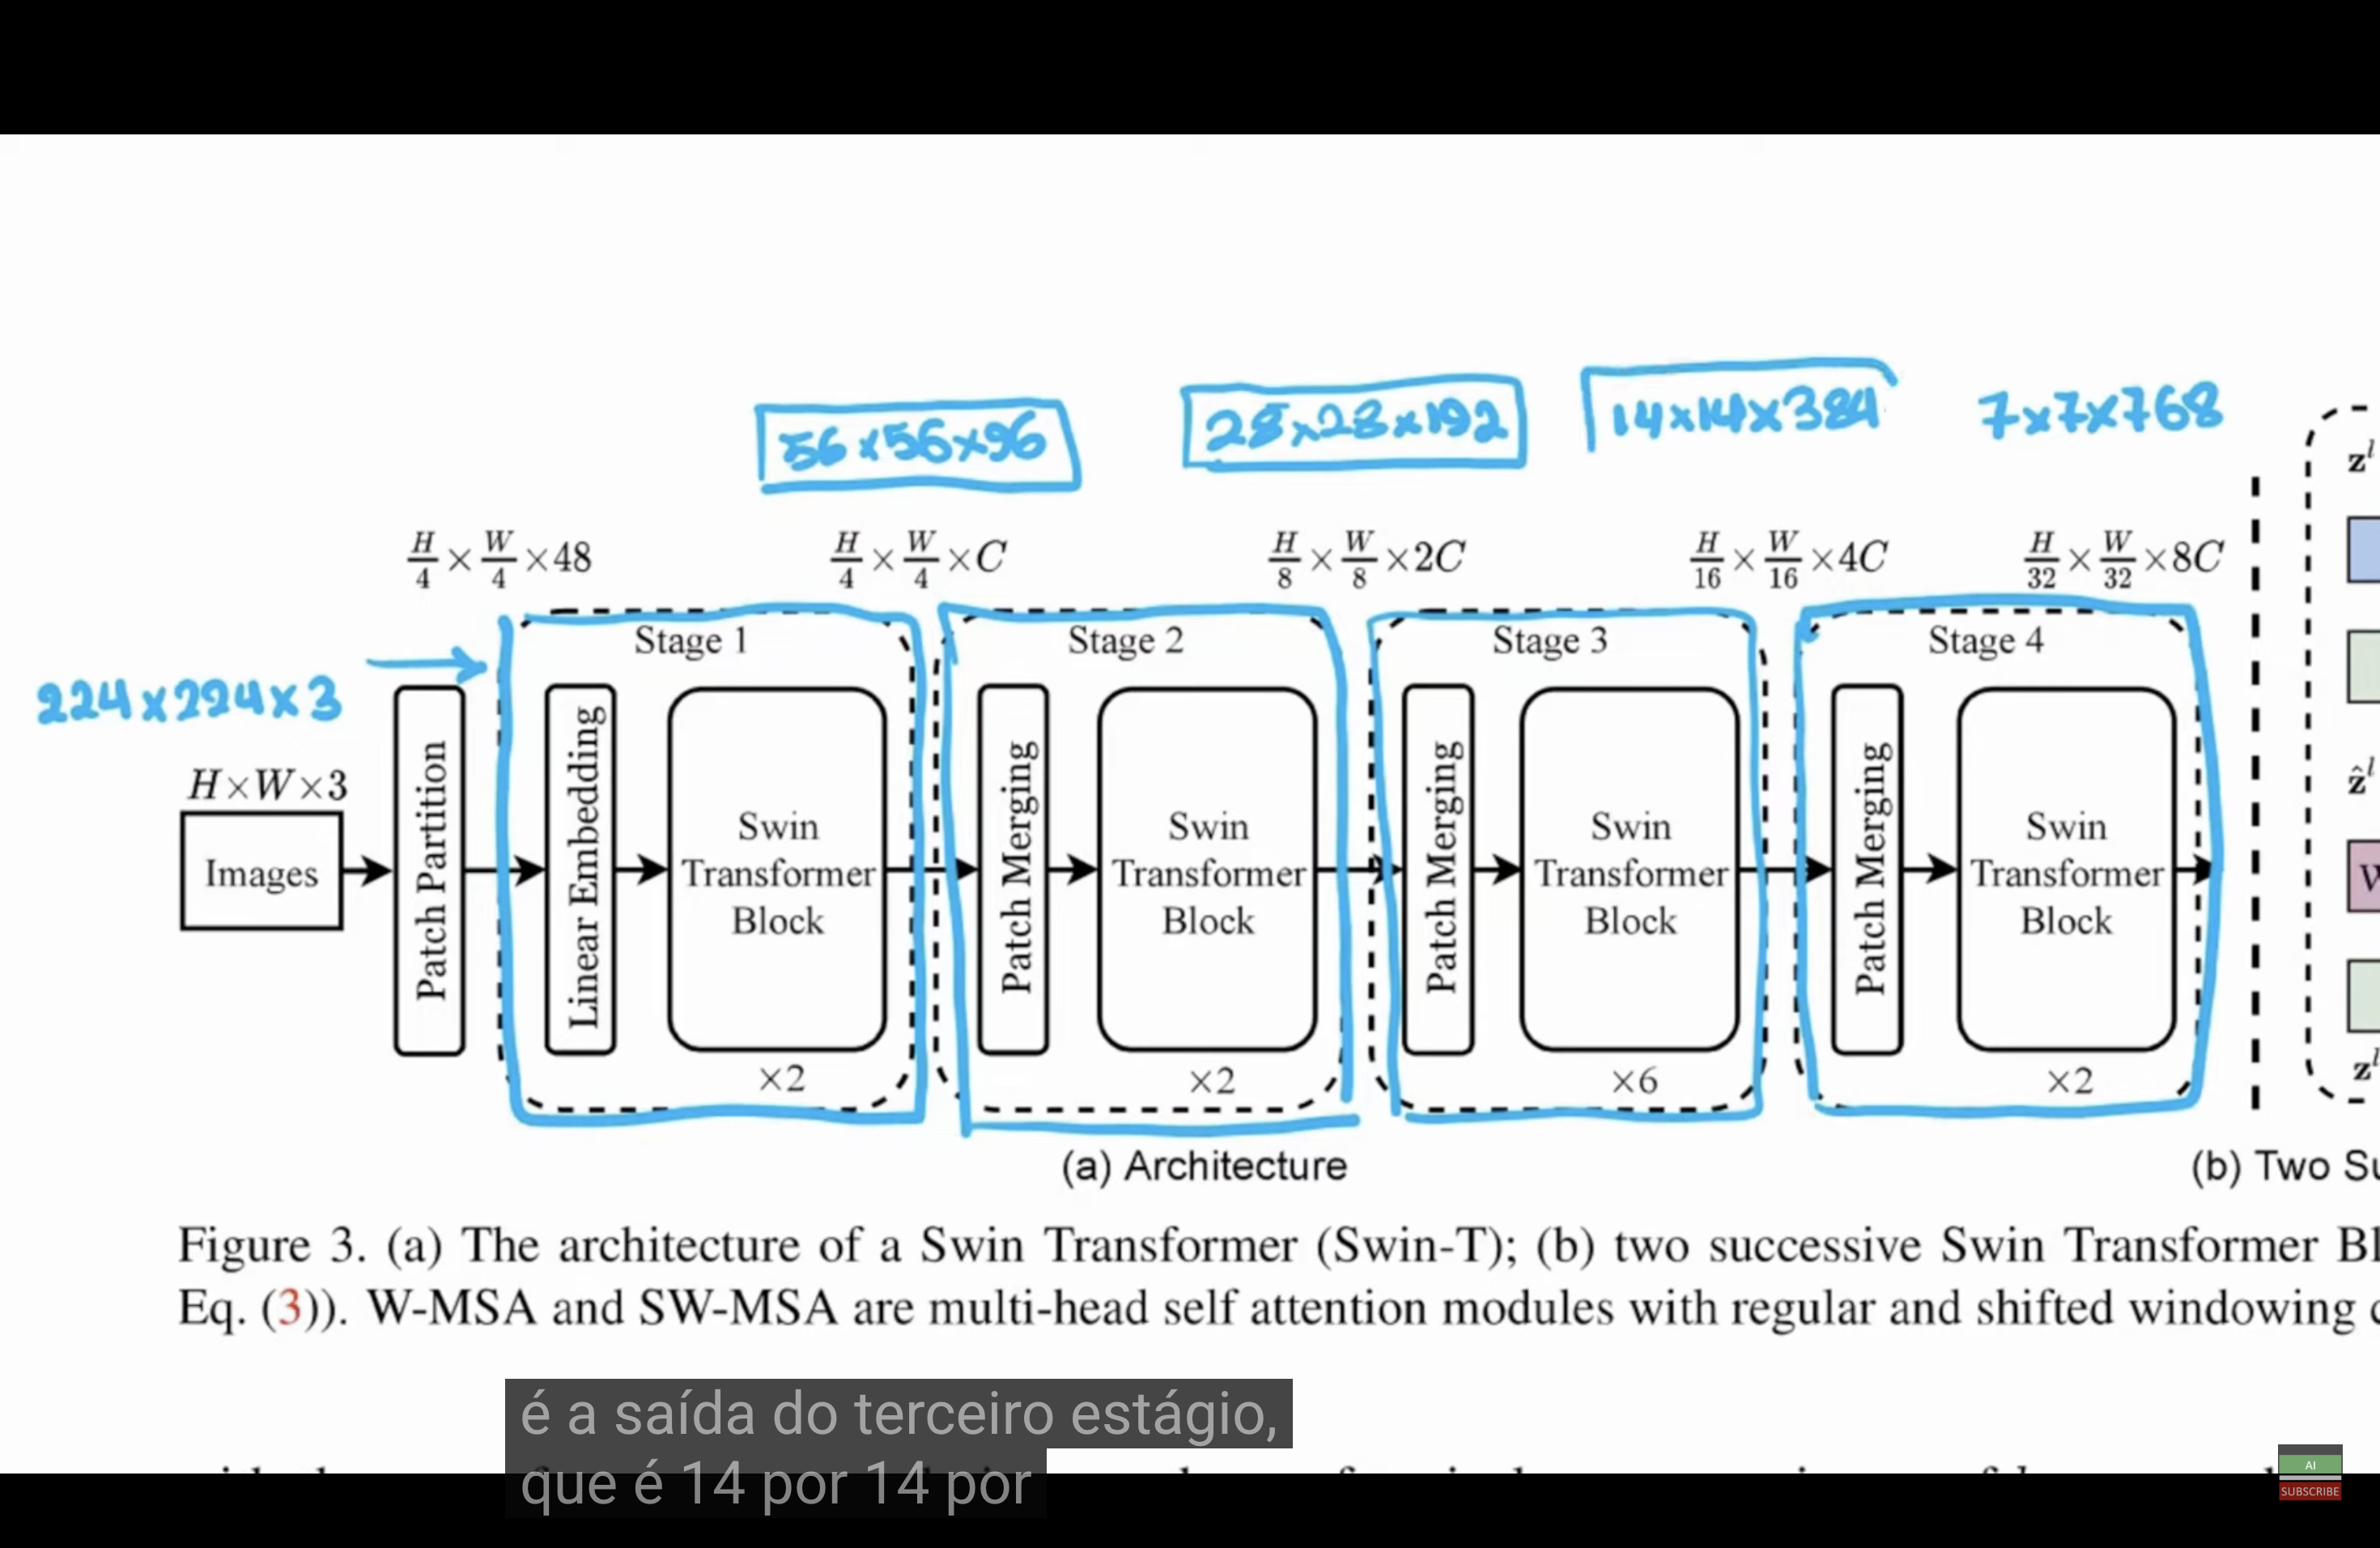

In [32]:
class StageModule(nn.Module):

  def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
               relative_pos_embedding):
    super().__init__()

    assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block'

    self.patch_partition = PatchMerging_Conv(in_channels=in_channels, out_channels=hidden_dimension,
                                             downscaling_factor=downscaling_factor)

    self.layers = nn.ModuleList([])
    # os numeros de camadas que obtemos como entrada precisa ser par
    # por isso temos 2, 2, 6, 2 pq precisamos de dois subblocos de swin transformer
    # quando as camadas são dois, quando estamos nesse loop podemos ver qe dividido por 2 temos um
    # entao fazemos apenas uma interação nesse loop para o MSA de janela e de janela deslocada
    for _ in range(layers // 2):
      self.layers.append(nn.ModuleList([
          # o primeiro é falso pra dizer que é uma janela normal
          SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                    shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
          # o segundo é true pra dizer que é uma janela deslocada
          SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                    shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding)
      ]))

      # essa função pode ser a entrada para os estágios 1, 2, 3 ou 4
      # sabemos que o x é o estágio
      # por exemplo
      # 1 - tamanho do lote
      # 3 - tês numeros de canais pq estamos usando RGB
      # por isso sabemos que a imagem é 244 por 244
      # para o segundo estagio a entrada o numero de canais é 96 e é 56 para o terceiro estagio
      # os canais de entrada é 192 e é 28 por 28
      # o ultimo estagio é o tamanho da entrada que é 384 para 14 por 14
      #(1, (3, 96, 192, 384), (224, 56, 28, 14), (224, 56, 28, 14))
  def forward(self, x):
    print(f"Entrada StageModule: {x.shape}")  # Debug
    # depois que temos a imagem o proximo passo seria redimencionar
    # essa imagem pra o nosso bloco string transformer
    # fazemos isso nessa linha e a saida seria:
    #(1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
    # entao essa linha so muda o tamanho e cria a estrutura de hierarquia
    x = self.patch_partition(x)
    print(f"Após PatchMerging: {x.shape}")   # Debug

    for regular_block, shifted_block in self.layers:
      # sabemos que o nosso swin transformer tem dois blocos suaves, um é MSA de janela
      # o outro é o MSA de janela deslocada
      # o bloco que usamos aqui chamamos de bloco regular e podemos ver que as simensoes
      # de entrada e saida sao semelhantes:
      #(1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
      x = regular_block(x)
      #print(f"Após regular_block {i}: {x.shape}")  # Debug
      #(1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
      x = shifted_block(x)
     #print(f"Após shifted_block {i}: {x.shape}")  # Debug
    # e no final teriamos essa dimensão
    #(1, 768, 7, 7)
    #return x.permute(0, 3, 1, 2)
    # CORREÇÃAO: Retornar no formato BCHW para o próximo estágio
    # return x.permute(0, 3, 1, 2)  # [1, H', W', C'] → [1, C', H', W']
    result = x.permute(0, 3, 1, 2)
    print(f"Saída StageModule: {result.shape}")  # Debug
    return result

In [33]:
class SwinTransformer(nn.Module):
  """

  """
  def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=100, head_dim=32, window_size=7,
               downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
    super().__init__()

    self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                              downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                              window_size=window_size, relative_pos_embedding=relative_pos_embedding)

    self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                              downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                              window_size=window_size, relative_pos_embedding=relative_pos_embedding)

    self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                              downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                              window_size=window_size, relative_pos_embedding=relative_pos_embedding)

    self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                              downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                              window_size=window_size, relative_pos_embedding=relative_pos_embedding)

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(hidden_dim * 8),
        nn.Linear(hidden_dim * 8, num_classes)
    )

  def forward(self, img):
    x = self.stage1(img)
    x = self.stage2(x)
    x = self.stage3(x) # (beatch, 768, 7, 7)
    x = self.stage4(x) # (beatch, 1, 768)
    x = x.mean(dim=[2, 3])
    return self.mlp_head(x)


In [34]:
# layers=(2, 2, 6, 2) - como temos no artigo na imagem vamos usar os mesmos valores
# pra o estagio 1 - 2 camadas. estagio 2 - 2 camadas, estagio 3 - 6 camadas, estagio 4 - 2 camadas
# no artigo temos outras arquiteturas sugeridas
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
  return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [35]:
# executando o codigo e tentando receber algumas saidas
net = swin_t(
    hidden_dim=96, # dimensao ocultas
    layers=(2, 2, 6, 2), # camdas
    heads=(3, 6, 12, 24), # cabeeças
    channels=3, # canais rgb
    num_classes=3, # classes
    head_dim=32, # cabeça dimensao
    window_size=7, # tamanho da janela
    downscaling_factors=(4, 2, 2, 2), # fator de reducao de escala
    relative_pos_embedding=True #
)

dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x) # 1, 3
print(logits)

Entrada StageModule: torch.Size([1, 3, 224, 224])
Após PatchMerging: torch.Size([1, 56, 56, 96])
Saída StageModule: torch.Size([1, 96, 56, 56])
Entrada StageModule: torch.Size([1, 96, 56, 56])
Após PatchMerging: torch.Size([1, 28, 28, 192])
Saída StageModule: torch.Size([1, 192, 28, 28])
Entrada StageModule: torch.Size([1, 192, 28, 28])
Após PatchMerging: torch.Size([1, 14, 14, 384])
Saída StageModule: torch.Size([1, 384, 14, 14])
Entrada StageModule: torch.Size([1, 384, 14, 14])
Após PatchMerging: torch.Size([1, 7, 7, 768])
Saída StageModule: torch.Size([1, 768, 7, 7])
tensor([[ 0.6249, -0.7261, -0.3723]], grad_fn=<AddmmBackward0>)


In [36]:
import torch.nn.functional as F

logits = net(dummy_x)
probabilities = F.softmax(logits, dim=-1)
predicted_class = torch.argmax(logits, dim=-1)

print(f"Logits: {logits}")
print(f"Probabilidades: {probabilities}")
print(f"Classe predita: {predicted_class}")

Entrada StageModule: torch.Size([1, 3, 224, 224])
Após PatchMerging: torch.Size([1, 56, 56, 96])
Saída StageModule: torch.Size([1, 96, 56, 56])
Entrada StageModule: torch.Size([1, 96, 56, 56])
Após PatchMerging: torch.Size([1, 28, 28, 192])
Saída StageModule: torch.Size([1, 192, 28, 28])
Entrada StageModule: torch.Size([1, 192, 28, 28])
Após PatchMerging: torch.Size([1, 14, 14, 384])
Saída StageModule: torch.Size([1, 384, 14, 14])
Entrada StageModule: torch.Size([1, 384, 14, 14])
Após PatchMerging: torch.Size([1, 7, 7, 768])
Saída StageModule: torch.Size([1, 768, 7, 7])
Logits: tensor([[ 0.6249, -0.7261, -0.3723]], grad_fn=<AddmmBackward0>)
Probabilidades: tensor([[0.6143, 0.1591, 0.2266]], grad_fn=<SoftmaxBackward0>)
Classe predita: tensor([0])


In [38]:
# Para classificação de imagens
def predict_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
        probabilities = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(logits, dim=-1)
    return predicted_class, probabilities

# Exemplo de uso
predicted_class, probs = predict_image(net, dummy_x)
print(f"Classe predita: {predicted_class.item()}")
print(f"Confiança: {probs.max().item():.2%}")

Entrada StageModule: torch.Size([1, 3, 224, 224])
Após PatchMerging: torch.Size([1, 56, 56, 96])
Saída StageModule: torch.Size([1, 96, 56, 56])
Entrada StageModule: torch.Size([1, 96, 56, 56])
Após PatchMerging: torch.Size([1, 28, 28, 192])
Saída StageModule: torch.Size([1, 192, 28, 28])
Entrada StageModule: torch.Size([1, 192, 28, 28])
Após PatchMerging: torch.Size([1, 14, 14, 384])
Saída StageModule: torch.Size([1, 384, 14, 14])
Entrada StageModule: torch.Size([1, 384, 14, 14])
Após PatchMerging: torch.Size([1, 7, 7, 768])
Saída StageModule: torch.Size([1, 768, 7, 7])
Classe predita: 0
Confiança: 61.43%
